# Price Prediction using RNN - LSTM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
csv_filepath:str = "../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv"
print(f"csv_filepath {csv_filepath}")
date_column:str = "Date "
open_column:str = "OPEN "
high_column:str = "HIGH "
low_column:str = "LOW "
close_column:str = "close "
volume_column:str = "VOLUME "
close_column_index:int = 3
np.set_printoptions(suppress=True)

csv_filepath ../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv


In [3]:
df = pd.read_csv(csv_filepath, date_parser=True, header=0)
print(f"df keys")
print(f"{df.keys()}")
# Sort DataFrame by date
df[date_column]=pd.to_datetime(df[date_column])
df.head()

df keys
Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2020-08-19,EQ,"1,835.00","1,835.90","1,818.05","1,820.70","1,827.55","1,827.95","1,828.01","2,499.90","1,473.45",2934730,"5,364,712,976.60",85358
1,2020-08-18,EQ,"1,801.10","1,825.40","1,795.95","1,800.55","1,819.05","1,820.70","1,813.53","2,499.90","1,473.45",3413536,"6,190,549,505.40",141811
2,2020-08-17,EQ,"1,805.00","1,807.85","1,783.85","1,791.70","1,801.95","1,800.55","1,795.17","2,499.90","1,473.45",4076960,"7,318,829,944.15",148103
3,2020-08-14,EQ,"1,818.60","1,823.75","1,773.25","1,804.85","1,793.75","1,791.70","1,796.65","2,499.90","1,473.45",6136766,"11,025,637,096.85",186319
4,2020-08-13,EQ,"1,818.50","1,823.65","1,799.55","1,814.20","1,810.00","1,804.85","1,807.52","2,499.90","1,473.45",3769538,"6,813,503,042.60",129725


In [4]:
df[date_column] = pd.to_datetime(df[date_column]).astype('datetime64[ns]')
df[open_column] = df[open_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[high_column] = df[high_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[low_column] = df[low_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[close_column] = df[close_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[volume_column] = df[volume_column].transform(func=lambda x: "".join(str(x).split(","))).astype(int)
df = df[[date_column, open_column, high_column, low_column, close_column, volume_column]]
df = df.sort_values(by=[date_column], ascending=True)
df.head()

,Date,OPEN,HIGH,LOW,close,VOLUME
485,2018-08-29,1959.4,1971.40,1944.70,1956.25,2367281
484,2018-08-30,1950.0,1964.45,1928.25,1934.15,2466442
483,2018-08-31,1940.9,1942.45,1908.05,1935.95,3856093
482,2018-09-03,1950.0,1950.00,1928.10,1944.80,2310201
481,2018-09-04,1939.0,1959.65,1939.00,1954.80,2928533


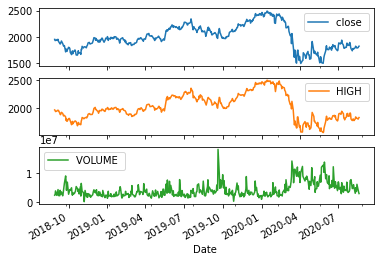

In [5]:
date_time = pd.to_datetime(df[date_column], format='%Y-%m-%d')

plot_cols = [close_column, high_column, volume_column]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## Add Indicators

In [6]:
from ta.momentum import rsi
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import VolumePriceTrendIndicator

# Add RSI Indicator
df["rsi"] = rsi(df[close_column], n=14)

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df[close_column], n=20, ndev=2)

# Add Bollinger Bands features
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# Add Width Size Bollinger Bands
df['bb_bbw'] = indicator_bb.bollinger_wband()

# Add Percentage Bollinger Bands
df['bb_bbp'] = indicator_bb.bollinger_pband()

# Initialize MACD Indicator
macd = MACD(df[close_column], n_slow=26, n_fast=12, n_sign=9)

# Add macd_diff features
df["macd"] = macd.macd()
df["macd_diff"] = macd.macd_diff()

# Initialize VPT Indicator
vpt = VolumePriceTrendIndicator(df[close_column], df[volume_column])
df["vpt"] = vpt.volume_price_trend()

# Drop rows with na values
df_with_ta = df.dropna(axis=0)

df_with_ta

,Date,OPEN,HIGH,LOW,close,VOLUME,rsi,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,macd,macd_diff,vpt
452,2018-10-19,1725.00,1760.95,1651.70,1660.25,5363667,36.105887,1746.1750,1842.079856,1650.270144,0.0,0.0,10.984564,0.052030,-44.661667,3.385745,-277014.691897
451,2018-10-22,1683.90,1689.70,1649.45,1658.30,4632839,35.940274,1737.5575,1832.520094,1642.594906,0.0,0.0,10.930584,0.082691,-47.095407,0.761604,-244797.094150
450,2018-10-23,1645.00,1710.00,1644.50,1686.75,3734275,40.246650,1729.9250,1814.935443,1644.914557,0.0,0.0,9.828223,0.246061,-46.195969,1.328834,58624.313076
449,2018-10-24,1715.00,1748.50,1706.60,1741.45,3598576,47.547638,1731.0625,1816.050528,1646.074472,0.0,0.0,9.819175,0.561112,-40.601298,5.538804,180764.724861
448,2018-10-25,1729.75,1740.00,1685.05,1694.45,4435395,42.717891,1727.1175,1811.207697,1643.027303,0.0,0.0,9.737635,0.305759,-39.504603,5.308399,-3007.849932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-08-13,1818.50,1823.65,1799.55,1804.85,3769538,48.765474,1820.7750,1906.973593,1734.576407,0.0,0.0,9.468341,0.407626,-5.921878,-1.860680,-44203.242074
3,2020-08-14,1818.60,1823.75,1773.25,1791.70,6136766,46.820777,1820.0675,1906.973859,1733.161141,0.0,0.0,9.549795,0.336793,-6.689988,-2.103032,-64139.406075
2,2020-08-17,1805.00,1807.85,1783.85,1800.55,4076960,48.314635,1819.7925,1906.909096,1732.675904,0.0,0.0,9.574344,0.389559,-6.509561,-1.538084,-24574.099434
1,2020-08-18,1801.10,1825.40,1795.95,1820.70,3413536,51.645237,1816.6450,1898.707677,1734.582323,0.0,0.0,9.034531,0.524707,-4.686611,0.227893,58338.878074


In [7]:
final_df = df_with_ta.drop([date_column], axis=1)
n = len(final_df)
train_df = final_df[0:int(n*0.7)]
val_df = final_df[int(n*0.65):int(n*0.99)]
test_df = final_df[int(n*0.85):]
train_df

,OPEN,HIGH,LOW,close,VOLUME,rsi,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,macd,macd_diff,vpt
452,1725.00,1760.95,1651.70,1660.25,5363667,36.105887,1746.1750,1842.079856,1650.270144,0.0,0.0,10.984564,0.052030,-44.661667,3.385745,-277014.691897
451,1683.90,1689.70,1649.45,1658.30,4632839,35.940274,1737.5575,1832.520094,1642.594906,0.0,0.0,10.930584,0.082691,-47.095407,0.761604,-244797.094150
450,1645.00,1710.00,1644.50,1686.75,3734275,40.246650,1729.9250,1814.935443,1644.914557,0.0,0.0,9.828223,0.246061,-46.195969,1.328834,58624.313076
449,1715.00,1748.50,1706.60,1741.45,3598576,47.547638,1731.0625,1816.050528,1646.074472,0.0,0.0,9.819175,0.561112,-40.601298,5.538804,180764.724861
448,1729.75,1740.00,1685.05,1694.45,4435395,42.717891,1727.1175,1811.207697,1643.027303,0.0,0.0,9.737635,0.305759,-39.504603,5.308399,-3007.849932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2433.00,2445.00,2388.50,2395.80,2543177,45.600813,2443.9225,2504.038650,2383.806350,0.0,0.0,4.919645,0.099754,15.222750,-11.292881,-36973.158439
139,2413.00,2471.70,2410.00,2431.60,6698252,51.406738,2444.8750,2503.559278,2386.190722,0.0,0.0,4.800595,0.386895,13.483042,-10.426071,43068.379976
138,2446.00,2447.50,2400.00,2404.25,2692713,47.257145,2443.3900,2504.555600,2382.224400,0.0,0.0,5.006618,0.180049,9.784604,-11.299607,69803.820505
137,2413.00,2428.70,2386.90,2415.00,2807667,48.999729,2440.8200,2502.221282,2379.418718,0.0,0.0,5.031201,0.289744,7.633012,-10.760959,-17733.152853


In [8]:
scaler = MinMaxScaler()
scaled_train_df = scaler.fit_transform(train_df)
scaled_train_df

array([[0.09512485, 0.08794125, 0.00870301, ..., 0.02257399, 0.58083218,
        0.        ],
       [0.04625446, 0.        , 0.00598332, ..., 0.        , 0.51739794,
        0.02152792],
       [0.        , 0.02505554, 0.        , ..., 0.00834268, 0.53110978,
        0.22427522],
       ...,
       [0.95243757, 0.93532461, 0.91321165, ..., 0.52758669, 0.22583829,
        0.23174541],
       [0.91319857, 0.91212046, 0.89737701, ..., 0.50762975, 0.2388592 ,
        0.17325288],
       [0.91795482, 0.91958776, 0.91865103, ..., 0.49044721, 0.25506039,
        0.1927081 ]])

In [9]:
X_train = []
Y_train = []
window_size = 30
for i in range(window_size, scaled_train_df.shape[0]):
    X_train.append(scaled_train_df[i-window_size: i])
    Y_train.append(scaled_train_df[i][close_column_index])

In [10]:
x_train = np.array(X_train)
y_train = np.array(Y_train)
x_train.shape, y_train.shape

((287, 30, 16), (287,))

## Building LSTM

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

In [12]:
model = Sequential()
model.add(LSTM(units=480, activation="tanh", return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.01))

model.add(GRU(units=240, activation="tanh", return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=120, activation="tanh", return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=60, activation="tanh", return_sequences=True))
model.add(Dropout(0.01))

model.add(LSTM(units=30, activation="tanh"))
model.add(Dropout(0.1))

model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 480)           954240    
_________________________________________________________________
dropout (Dropout)            (None, 30, 480)           0         
_________________________________________________________________
gru (GRU)                    (None, 30, 240)           519840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 240)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 120)           173280    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 120)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 60)            3

In [13]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())

In [14]:
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
9/9 [==============================] - 6s 677ms/step - loss: 0.0666
Epoch 2/20
9/9 [==============================] - 5s 595ms/step - loss: 0.0148

### Validation

In [15]:
val_past_60_days = train_df.tail(window_size)
val_df = val_past_60_days.append(val_df, ignore_index=True)
val_df.head()

,OPEN,HIGH,LOW,close,VOLUME,rsi,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,macd,macd_diff,vpt
0,2415.00,2425.00,2378.15,2404.10,5053198,65.092053,2337.5525,2434.669175,2240.435825,0.0,0.0,8.309261,0.842616,52.513568,5.227695,-72322.672807
1,2404.00,2433.80,2390.00,2422.65,1976677,67.102710,2343.9575,2445.672918,2242.242082,0.0,0.0,8.678947,0.886827,52.961399,4.540421,-1089.854624
2,2420.60,2444.95,2402.95,2412.75,2813782,64.952478,2349.3625,2453.605657,2245.119343,0.0,0.0,8.874165,0.804037,51.918972,2.798395,3753.675250
3,2412.75,2433.35,2404.30,2414.10,1480323,65.116630,2353.2525,2461.003001,2245.501999,0.0,0.0,9.157581,0.782354,50.618278,1.198161,-10670.053769
4,2427.00,2449.55,2418.55,2444.15,2080901,68.637834,2359.9725,2472.682369,2247.262631,0.0,0.0,9.551795,0.873426,51.419521,1.599523,26730.719225


In [16]:
scaled_val_df = scaler.transform(val_df)
scaled_val_df.shape

(184, 16)

In [17]:
X_val = []
Y_val = []
for i in range(window_size, scaled_val_df.shape[0]):
    X_val.append(scaled_val_df[i-window_size: i])
    Y_val.append(scaled_val_df[i][close_column_index])

In [18]:
x_val = np.array(X_val)
y_val = np.array(Y_val)
x_val.shape, y_val.shape

((154, 30, 16), (154,))

In [26]:
y_val_predicted = model.predict(x_val)
y_val_predicted.shape

(154, 1)

In [27]:
scaler.scale_

array([0.00118906, 0.00123426, 0.00120875, 0.00119904, 0.00000006,
       0.02449045, 0.00136708, 0.00138732, 0.00131042, 1.        ,
       1.        , 0.05782188, 0.63426815, 0.00927543, 0.02417333,
       0.00000067])

In [28]:
scale = 1 / scaler.scale_
scale, scaler.data_min_, scaler.data_max_


(array([     841.        ,      810.2       ,      827.3       ,
             834.        , 18079131.        ,       40.83224595,
             731.4875    ,      720.81536249,      763.11487893,
               1.        ,        1.        ,       17.29448999,
               1.57662023,      107.8116879 ,       41.36790057,
         1496549.64108281]),
 array([   1645.        ,    1689.7       ,    1644.5       ,
           1658.3       ,  124505.        ,      33.44862067,
           1714.5575    ,    1786.77056166,    1626.90145073,
              0.        ,       0.        ,       3.64189904,
             -0.22564075,     -47.09540742,     -20.64206291,
        -277014.69189683]),
 array([    2486.        ,     2499.9       ,     2471.8       ,
            2492.3       , 18203636.        ,       74.28086661,
            2446.045     ,     2507.58592416,     2390.01632966,
               1.        ,        1.        ,       20.93638903,
               1.35097947,       60.71628048,   

In [29]:
Y_predicted = y_val_predicted*scale[close_column_index] + scaler.data_min_[close_column_index]
Y_values = scaler.inverse_transform(scaled_val_df)
Y_actual = Y_values[:, close_column_index][window_size:]
Y_predicted.shape, Y_actual.shape

((154, 1), (154,))

## Visualization

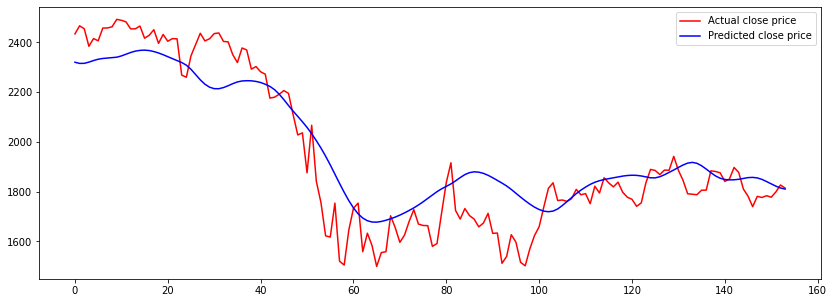

In [30]:
plt.figure(figsize=(14,5))
plt.plot(Y_actual, color="red", label="Actual close price")
plt.plot(Y_predicted, color="blue", label="Predicted close price")
plt.legend()
plt.show()
